## Monitoring Results
---

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu
from smart_open import open
import pickle as pkl

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load config and set local variables with config["mconfig"]
with open("../../config.json", "r") as f:
    config = json.load(f)
    
mconfig = config["monitoring_config"]
locals().update(mconfig)   # this would set k-v pairs in mconfig as local variables
print(mconfig.keys())

dict_keys(['mmonth', 'dev_df_path', 'monitoring_dates', 'prod_data_dates', 'data_output_path', 'artifact_path', 'date_sample_start', 'date_sample_end', 'model_paths', 'prev_test_df_path', 'modeling_df_path', 'test_df_path', 'prod_dfs_path'])


In [3]:
# artifacts path
os.makedirs(artifact_path, exist_ok=True)

test_dfs = OrderedDict()

In [4]:
# read data
df = pd.read_parquet(test_df_path)

In [5]:
models = {}
for mname, mpath in model_paths.items():
    with open(mpath, "rb") as f:
        models[mname] = pkl.load(f)

### Active Accounts

  0%|                                                                                                    | 0/6 [00:00<?, ?it/s]

2021-04-01 (120297, 98)
data imbalance:  53.39414114513982
2021-04-01 (120297, 98)
data imbalance:  53.39414114513982


 17%|███████████████▎                                                                            | 1/6 [00:15<01:15, 15.08s/it]

2021-05-01 (124921, 98)
data imbalance:  46.54284649776453
2021-05-01 (124921, 98)
data imbalance:  46.54284649776453


 33%|██████████████████████████████▋                                                             | 2/6 [00:30<01:00, 15.23s/it]

2021-06-01 (127955, 98)
data imbalance:  42.524094383516115
2021-06-01 (127955, 98)
data imbalance:  42.524094383516115


 50%|██████████████████████████████████████████████                                              | 3/6 [00:46<00:46, 15.49s/it]

2021-07-01 (139511, 98)
data imbalance:  41.153687315634215
2021-07-01 (139511, 98)
data imbalance:  41.153687315634215


 67%|█████████████████████████████████████████████████████████████▎                              | 4/6 [01:04<00:32, 16.12s/it]

2021-08-01 (153460, 98)
data imbalance:  48.70199936528086
2021-08-01 (153460, 98)
data imbalance:  48.70199936528086


 83%|████████████████████████████████████████████████████████████████████████████▋               | 5/6 [01:23<00:17, 17.07s/it]

2021-09-01 (172501, 98)
data imbalance:  71.10511129431163
2021-09-01 (172501, 98)
data imbalance:  71.10511129431163


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:44<00:00, 17.47s/it]


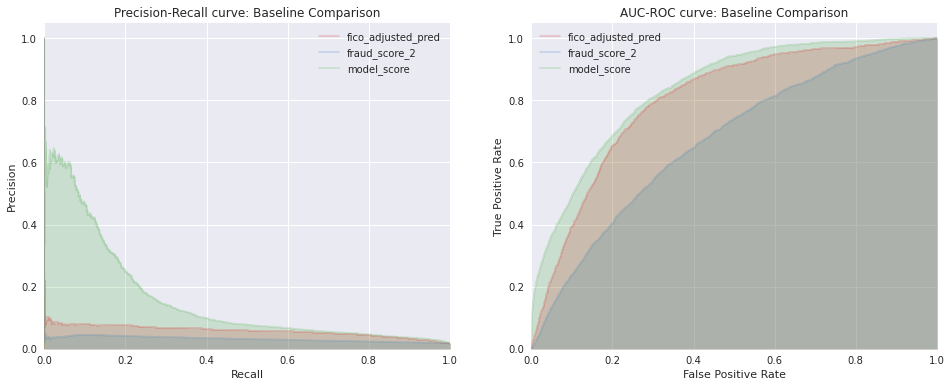

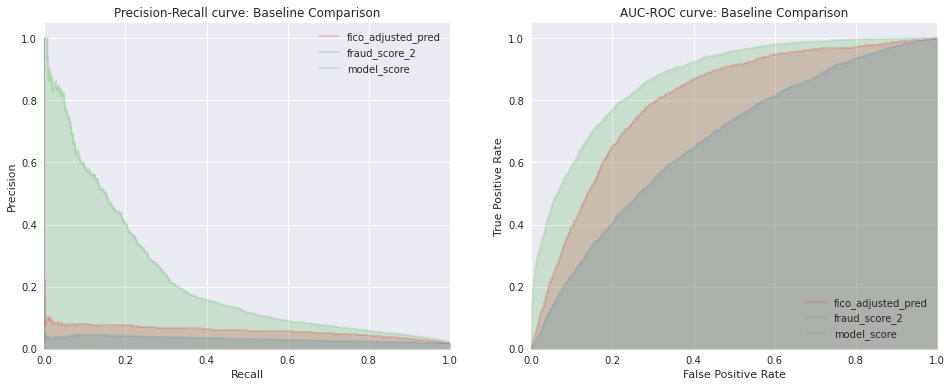

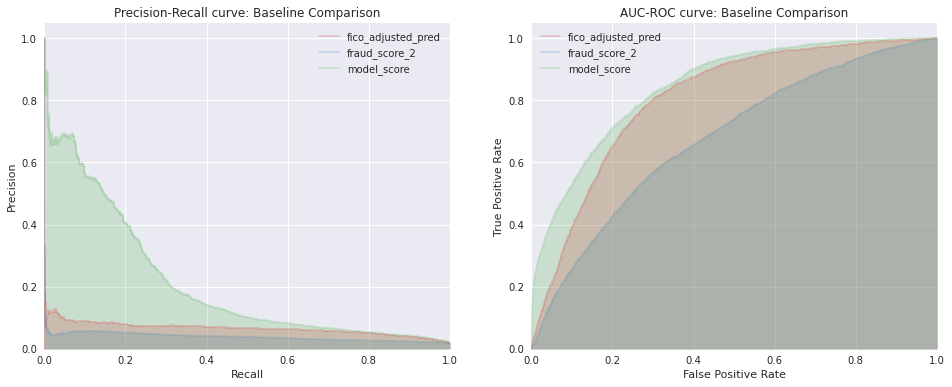

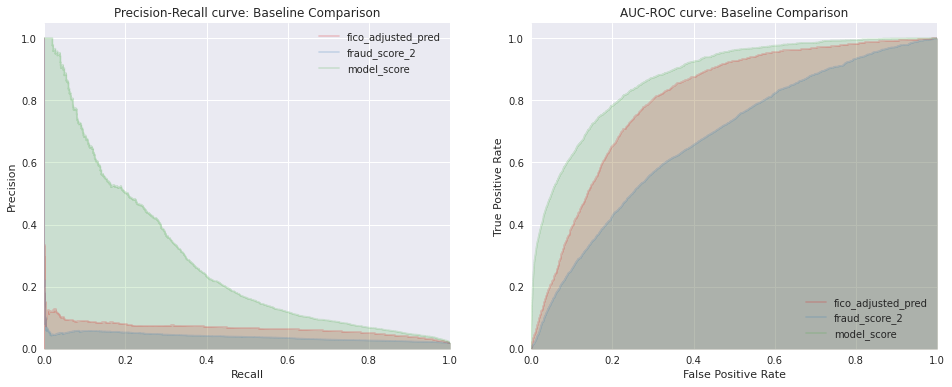

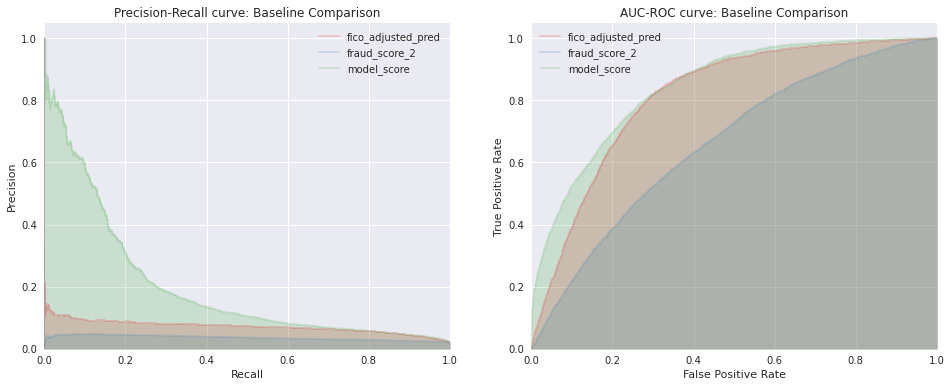

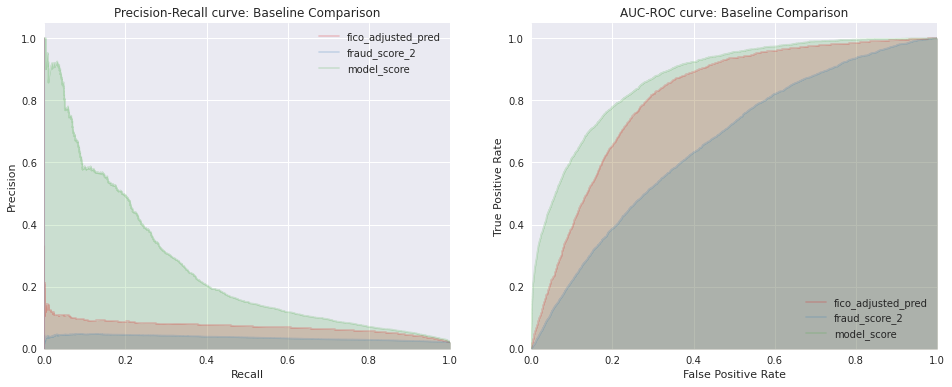

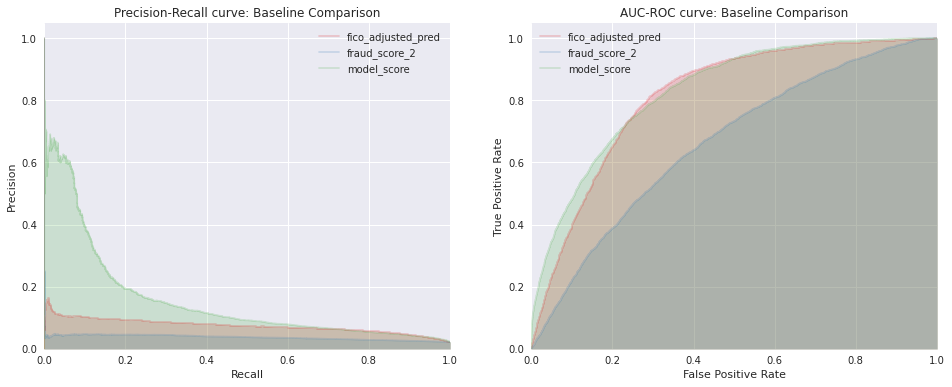

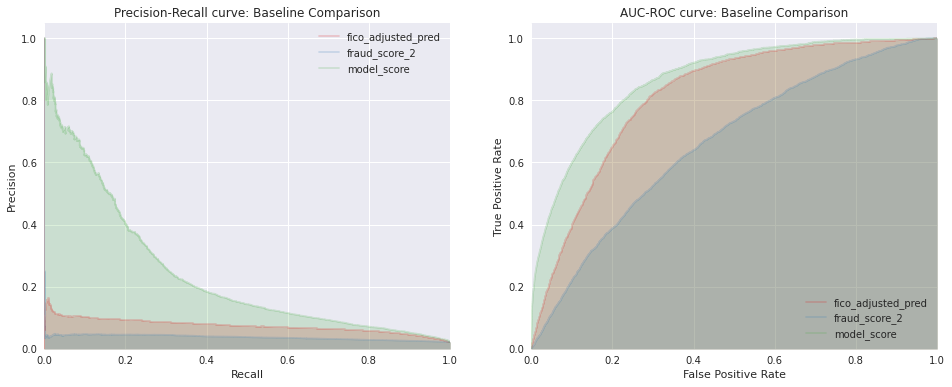

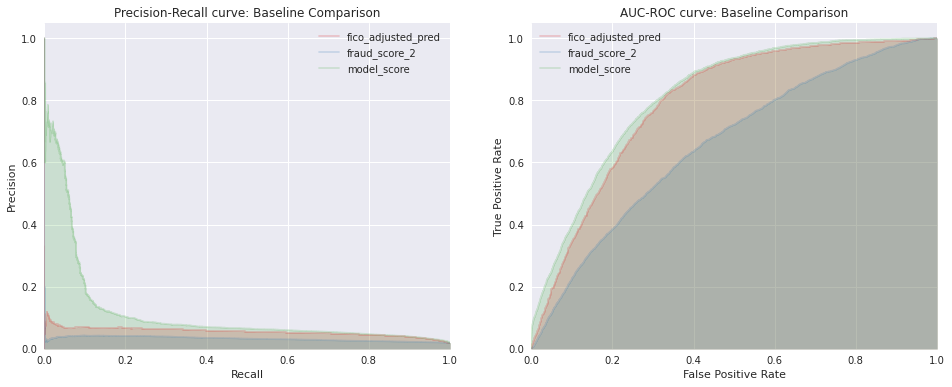

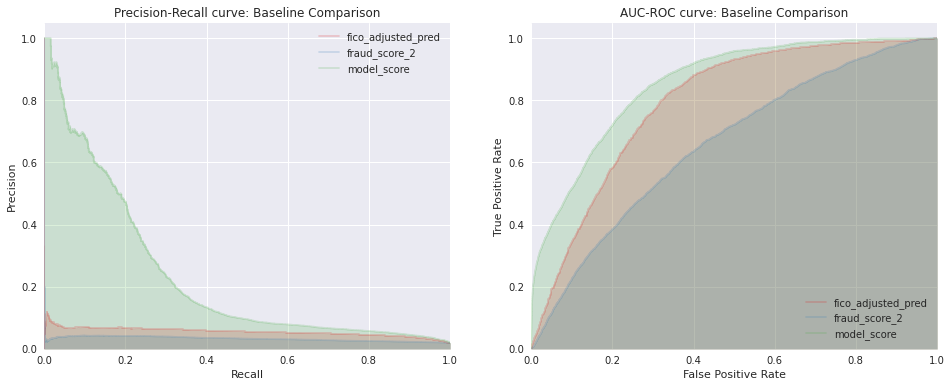

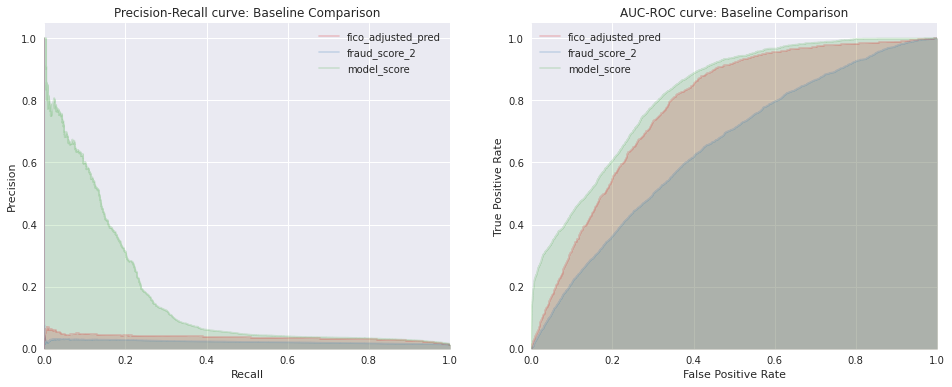

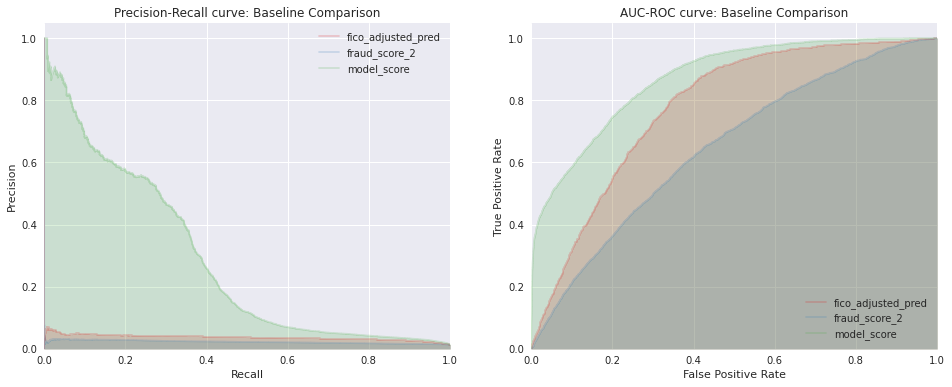

In [6]:
# get all the snapshots
for dt_str in tqdm(monitoring_dates):
    for mname, model in models.items(): 

        dt = pd.to_datetime(dt_str)

        # set folder:
        mntr_path = os.path.join(artifact_path, "monitoring", f"{mname}_{dt_str}_active")
        os.makedirs(mntr_path, exist_ok=True)
        
        # get data on that date
        df_ = df[df.is_static 
                 & (df.sample_date == dt)]
        
        # should have been processed when loaded, if not uncomment
        df_ = mu.prep_customer_data(df_)  # add is_active flag here
        df_ = df_[df_.is_active]
        print(dt_str, df_.shape)

        # see data imbalance
        print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])


        # make model pred and score
        df_["model_pred"] = model.predict_proba(df_[model.feature_name_])[:,1]
        df_["model_score"] = mu.scale_scores(df_["model_pred"])

        # insert into records
        test_dfs[dt_str] = df_
        pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
        report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)

        # store report in monitoring
        report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))

        # model prediction
        mntr.get_segmented_performances(
            {dt_str: df_},
            "target",
            ["model_score"],
            mntr_path,
            model_name="customer_risk",
        )

        # on vs fico adjusted - only valid fico
        mntr.get_model_vs_baseline(
            df_[df_.fico_score.between(300,850)],
            "target",
            "model_score",
            "fico_adjusted_pred",
            mntr_path,
        )

        # auc/pr plots - on valid fico and sigma score
        plot_df = df_  # bad style
        plot_df = plot_df[
            ~plot_df[pred_cols].isna().any(axis=1) 
            & plot_df["fico_score"].between(300, 850)
        ]
        mntr.save_valid_performance_plots(
            {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
        )

### Full Population
---

  0%|                                                                                                    | 0/6 [00:00<?, ?it/s]

2021-04-01 (831574, 91)
data imbalance:  167.0162683269733
2021-04-01 (831574, 91)
data imbalance:  167.0162683269733


 17%|███████████████▎                                                                            | 1/6 [01:27<07:17, 87.52s/it]

2021-05-01 (873053, 91)
data imbalance:  163.1569800037376
2021-05-01 (873053, 91)
data imbalance:  163.1569800037376


 33%|██████████████████████████████▋                                                             | 2/6 [02:59<05:55, 88.90s/it]

2021-06-01 (910550, 91)
data imbalance:  154.85544217687075
2021-06-01 (910550, 91)
data imbalance:  154.85544217687075


 50%|██████████████████████████████████████████████                                              | 3/6 [04:36<04:34, 91.37s/it]

2021-07-01 (960159, 91)
data imbalance:  156.7862508164598
2021-07-01 (960159, 91)
data imbalance:  156.7862508164598


 67%|█████████████████████████████████████████████████████████████▎                              | 4/6 [06:19<03:09, 94.86s/it]

2021-08-01 (1017619, 91)
data imbalance:  184.41808626313883
2021-08-01 (1017619, 91)
data imbalance:  184.41808626313883


 83%|████████████████████████████████████████████████████████████████████████████▋               | 5/6 [08:09<01:39, 99.25s/it]

2021-09-01 (1095317, 91)
data imbalance:  248.99227097067515
2021-09-01 (1095317, 91)
data imbalance:  248.99227097067515


100%|███████████████████████████████████████████████████████████████████████████████████████████| 6/6 [10:06<00:00, 101.10s/it]


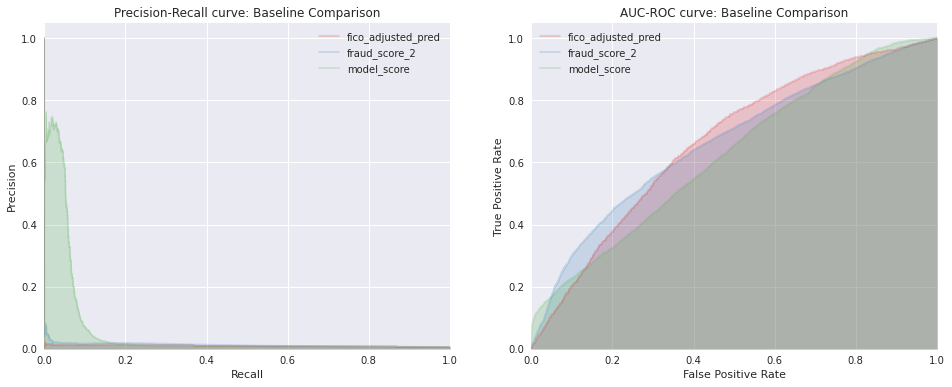

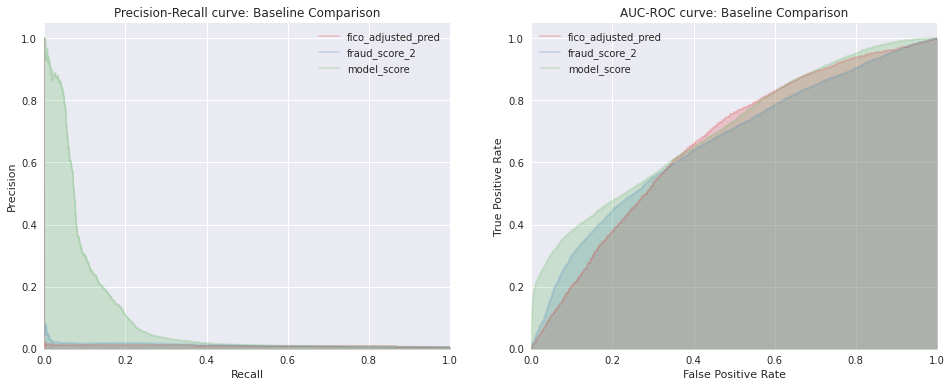

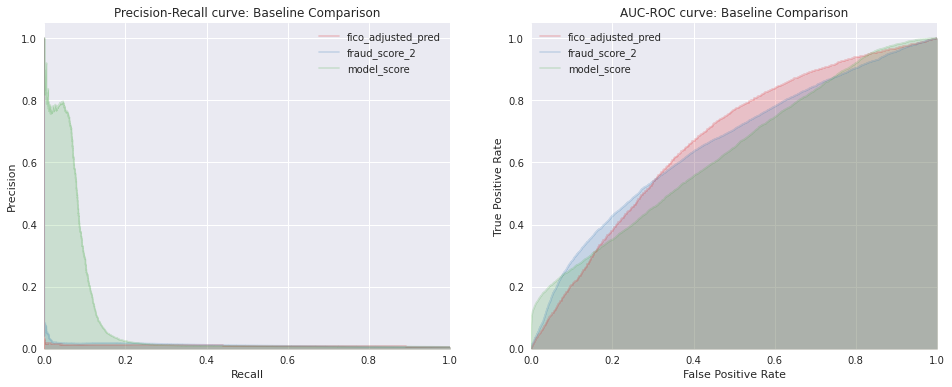

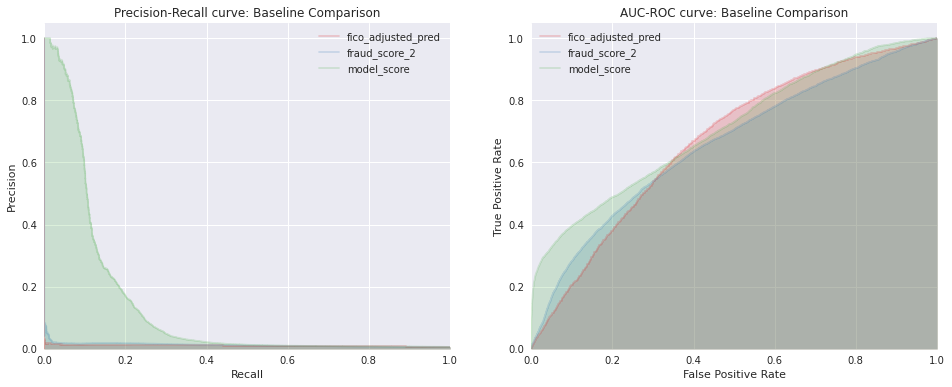

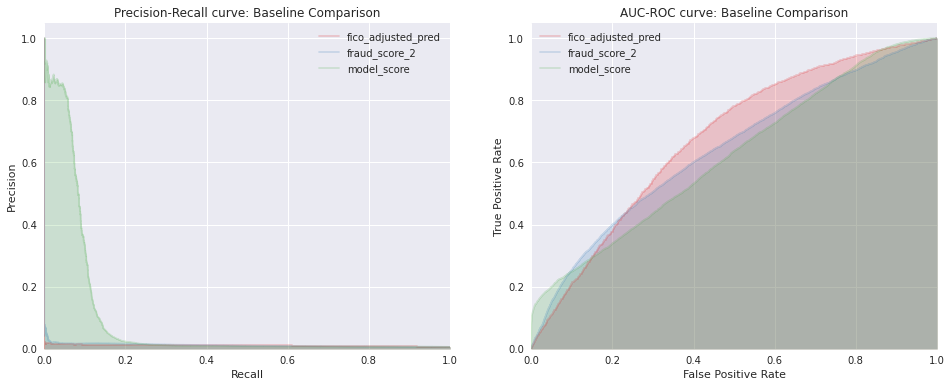

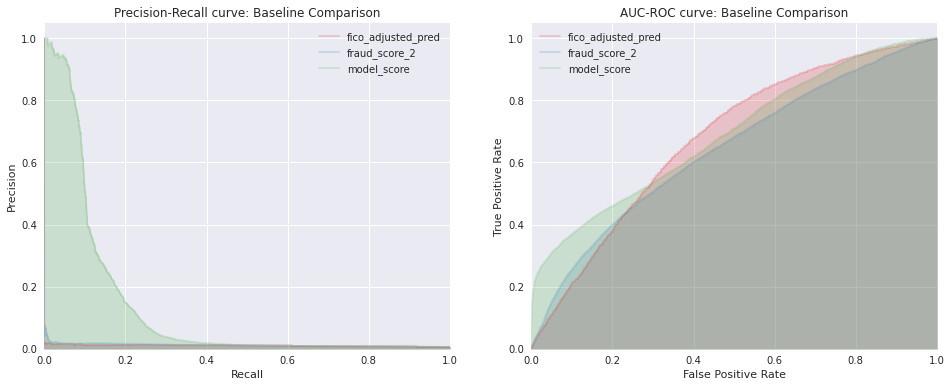

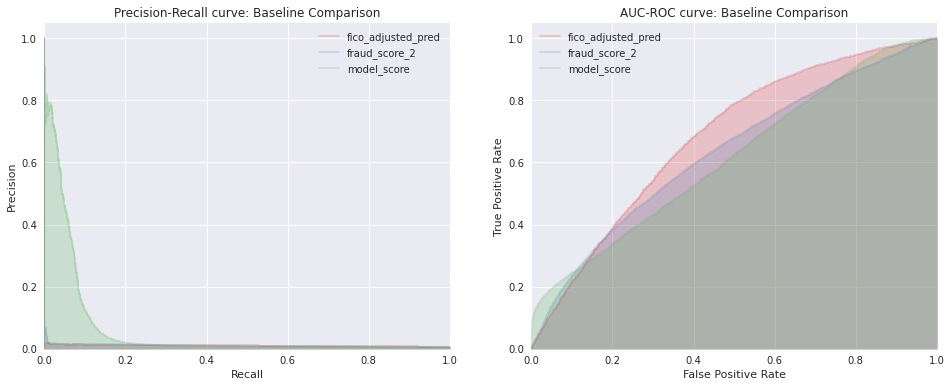

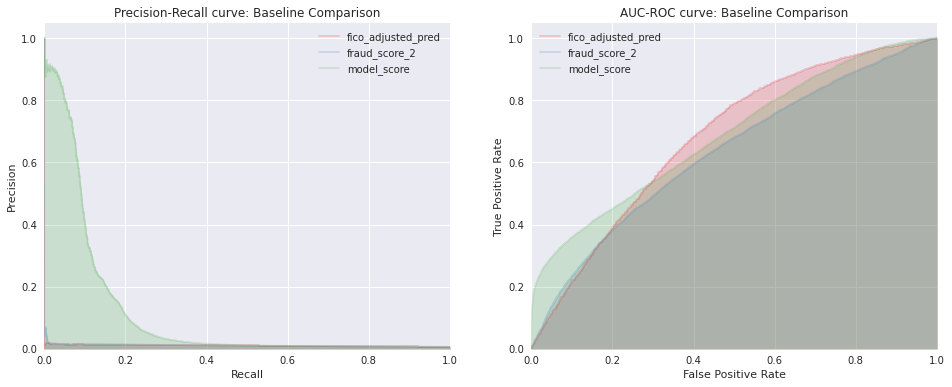

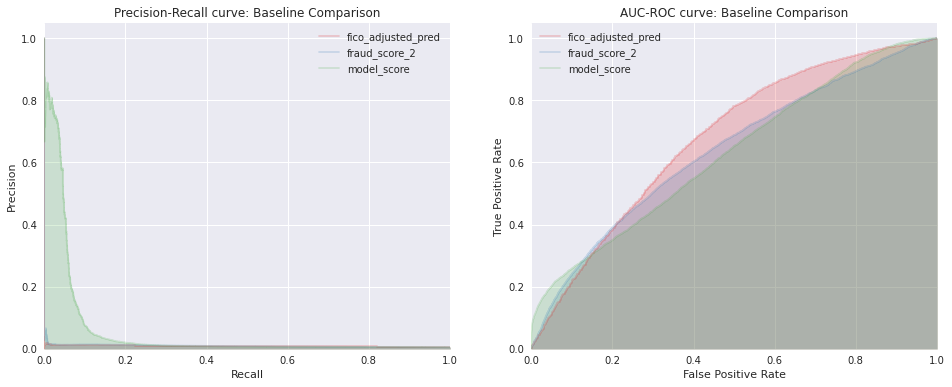

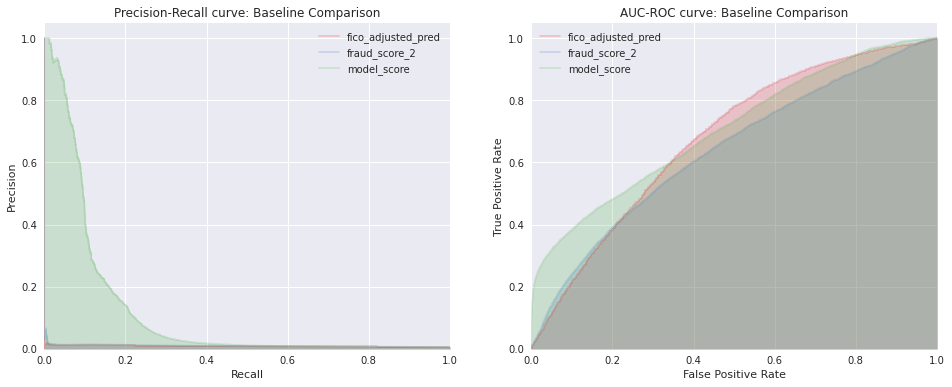

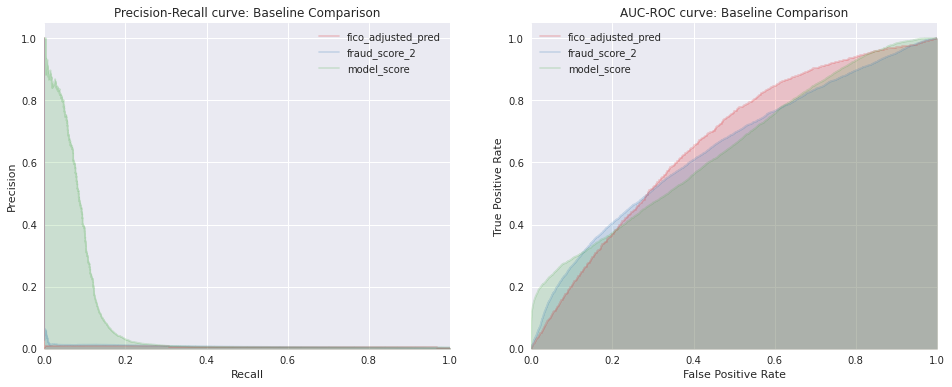

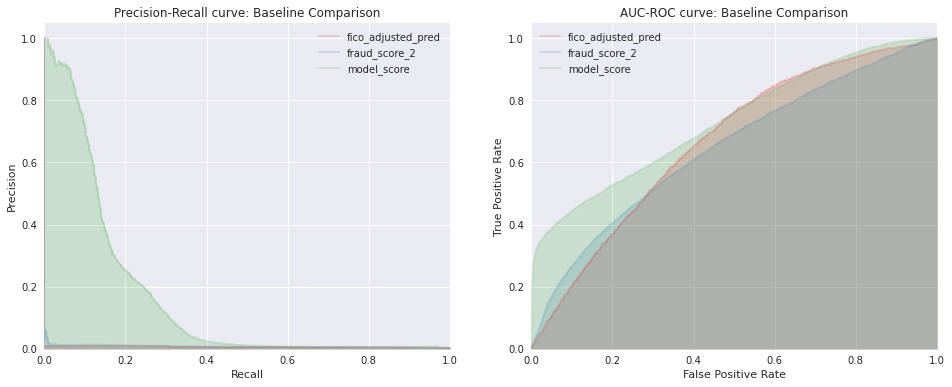

In [7]:
# get all the snapshots
for dt_str in tqdm(monitoring_dates):
    for mname, model in models.items(): 

        dt = pd.to_datetime(dt_str)

        # set folder:
        mntr_path = os.path.join(artifact_path, "monitoring", f"{mname}_{dt_str}_full")        
        os.makedirs(mntr_path, exist_ok=True)

        # get data on that date
        df_ = df[df.is_static 
                 & (df.sample_date == dt)]
        print(dt_str, df_.shape)

        # see data imbalance
        print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])

        # should have been processed when loaded, if not uncomment
        df_ = mu.prep_customer_data(df_)

        # make model pred and score
        df_["model_pred"] = model.predict_proba(df_[model.feature_name_])[:,1]
        df_["model_score"] = mu.scale_scores(df_["model_pred"])

        # insert into records
        test_dfs[dt_str] = df_
        pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
        report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)

        # store report in monitoring
        report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))

        # model prediction
        mntr.get_segmented_performances(
            {dt_str: df_},
            "target",
            ["model_score"],
            mntr_path,
            model_name="customer_risk",
        )

        # on vs fico adjusted - only valid fico
        mntr.get_model_vs_baseline(
            df_[df_.fico_score.between(300,850)],
            "target",
            "model_score",
            "fico_adjusted_pred",
            mntr_path,
        )

        # auc/pr plots - on valid fico and sigma
        plot_df = df_.copy()
        plot_df = plot_df[
            ~plot_df[pred_cols].isna().any(axis=1) 
            & plot_df["fico_score"].between(300, 850)
        ]
        mntr.save_valid_performance_plots(
            {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
        )